# Игры — Формирование модели монетизации

Цель данного проекта - предложить модель монетизации для мобильной игры "Космические братья".  
Подход на данный момент уже определен создателями игры - рекламу будут показывать при создании игровой постройки. При разработке модели нужно учесть, что слишком назойливая реклама может отпугнуть пользователя.  
Установленная цель - достичь окупаемости маркетинговых расходов на привлечение игроков за то время, что игроки тратят на прохождение первого уровня.  
В нашем распоряжении данные первой когорты игроков: датасет с информацией о времени события, типе события (постройка здания, завершение уровня, завершение проекта), типе здания, user id.  

Помимо основного датасета есть два датасета с информацией о рекламных активностях:    

Датасет с информацией о переходах пользователей по объявлению и стоимости кликов. 

Датасет с id пользлователя и информаией об источник, с которого пришел пользователь.   

В рамках исследования:  
проведем исследовательский анализ данных;  
проверим как разные события влияют на совершение целевого события (завершения уровня);  
проверим статистические гипотезы

## Материалы
* [Презентация](https://drive.google.com/file/d/1Wf0uSkARfI3tSqKlpmiGO_iugImwIYkH/view?usp=sharing)
* [Дашборд](https://public.tableau.com/views/SpaceBrothers_16317415176740/-2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
!pip install matplotlib -U

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.3 MB 1.4 MB/s eta 0:00:01


In [3]:
pip install seaborn==0.11.2

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Предобработка данных

Изучим таблицу с событиями

In [4]:
#В проекте использован датасет предоставленный Яндекс.Практикум
actions = pd.read_csv('/***/***.csv')

In [5]:
actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


Проверим наличие пропусков в таблице

In [6]:
actions.isna().mean()

event_datetime    0.000000
event             0.000000
building_type     0.056643
user_id           0.000000
project_type      0.986243
dtype: float64

In [7]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB


Есть пропуски в типах зданий и в типах проектов, но это нормально, так как тип здания заполнен только при постройке здания, а тип проекта - при реализации проекта. Обработка пропусков не требуется.

Тип данных в колонке event_datetime заменим на дату

In [8]:
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'], format = '%Y-%m-%d %H:%M:%S')

In [9]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null datetime64[ns]
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


Проверим, что при постройке здания всегда указан его тип

In [10]:
actions.query('event == "building"').isna().mean()

event_datetime    0.0
event             0.0
building_type     0.0
user_id           0.0
project_type      1.0
dtype: float64

Проверим, что при реализации проекта всегда указан тип проекта

In [11]:
actions.query('event == "project"').isna().mean()

event_datetime    0.0
event             0.0
building_type     1.0
user_id           0.0
project_type      0.0
dtype: float64

Проверим наличие дубликатов

In [12]:
actions.duplicated().sum()

1

Обнаружен один дубликат. 

In [13]:
actions.loc[actions.duplicated(), :]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


После получения дополнительной информации, мы выяснили, что постройка двух зданий одним игроком в течении одной секунды технически невозможна - это баг.  
О баге сообщим технической команде, а дубликат удаляем. 

In [14]:
actions = actions.drop_duplicates()

Изучим таблицу с источниками прихода пользователей

In [15]:
#В проекте использован датасет предоставленный Яндекс.Практикум
source = pd.read_csv('/***/***.csv')

In [16]:
source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


Проверим наличие пропусков

In [17]:
source.isna().mean()

user_id    0.0
source     0.0
dtype: float64

Проверим наличие дубликатов

In [18]:
source.duplicated().sum()

0

Убедимся, что для каждого пользователя указан только один источник

In [19]:
source.duplicated(subset = ['user_id']).sum()

0

In [20]:
source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Изучим таблицу с расходами на маркетинг

In [21]:
costs = pd.read_csv('/datasets/ad_costs.csv')

In [22]:
costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


Проверим наличие пропусков

In [23]:
costs.isna().mean()

source    0.0
day       0.0
cost      0.0
dtype: float64

Проверим наличие дубликатов

In [24]:
costs.duplicated().sum()

0

Проверим типы данных

In [25]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


Дату переведем в формат даты

In [26]:
costs['day'] = pd.to_datetime(costs['day'], format = '%Y-%m-%d')

В целом вопросов по качеству предоставленных данных почти не возникло: обработка пропусков не потребовалась, обнаружен и удален всего один дубликат, в нескольких местах изменили тип данных на дату для возможности дальнейшей обработки.

## Исследовательский анализ данных

Проверим, за какой период у нас есть данные по активностям игроков

In [27]:
actions['event_datetime'].min()

Timestamp('2020-05-04 00:00:01')

In [28]:
actions['event_datetime'].max()

Timestamp('2020-06-05 12:32:49')

Нам доступны данные о пользовательской активности чуть больше чем за месяц: с 4 мая 2020 по 5 июля 2020

Проверим, за какой период у нас есть данные по рекламным расходам;

In [29]:
costs['day'].min()

Timestamp('2020-05-03 00:00:00')

In [30]:
costs['day'].max()

Timestamp('2020-05-09 00:00:00')

Данные по рекламным расходам приведены за период с 3 мая по 9 мая. При этом мы изучаем когорту пользователей, зарегистрировавшихся с 4 по 10 мая. Нам известно, что реклама закупается на день вперед - поэтому все данные по рекламных расходам относятся к изучаемой когорте. 

Проверим, какие события, типы зданий, проектов есть в наборе данных;

In [31]:
actions['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [32]:
actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [33]:
actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

Всё соответствует тех. заданию

Проверим, что для всех пользователей из actions есть источник в source;

In [34]:
set(actions['user_id'].unique()).issubset(source['user_id'].unique())

True

In [35]:
costs['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

In [36]:
source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Для всех пользователей заполнен источник из тех, по которым у нас есть данные о расходах

## Анализ влияния событий на совершение целевого события

Целевое событие: завершение уровня. 

Исследуем количество игроков, завершивших уровень победой на врагом, и реализацией проекта;  
Мы можем выделить игроков, завершивших уровень победой над врагом - у таких игроков не заполнена информация о реализации проекта. 

In [37]:
finished_stage_1 = actions.query('event == "finished_stage_1"')

In [38]:
finished_stage_1.head()

,event_datetime,event,building_type,user_id,project_type
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN
19650,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN


In [39]:
len(finished_stage_1)

5817

5817 игроков из первой когорты завешили 1й уровень к 5 июня 2020 г.

Найдем игроков, завершивших уровень, но при этом не завершивших проект

In [40]:
project_completed = actions.query('event == "project"')

In [41]:
project_completed['user_id']

47121     e3c66498-9d45-4000-9392-f81e6796e7da
57398     936e7af6-8338-4703-a1df-fc6c3f5b8e34
58797     a4491c86-c498-4f74-a56e-65c136d0e9a1
61174     85d9e675-562b-4329-8bbd-14d3b39096be
63770     1889ca71-3c57-4e61-9ea6-a711971bbf0a
                          ...                 
135602    9d98001c-7e14-40d7-896e-46b3047365fd
135603    df4a1e13-eba9-4928-a7cf-ee303d6f80f9
135609    82e46f34-e243-4728-8e20-2e171fc33ea4
135617    fe032991-71e0-48c5-889f-4c3805ba4c9b
135630    d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8
Name: user_id, Length: 1866, dtype: object

In [42]:
finished_stage_1['user_id']

6659      ced7b368-818f-48f6-9461-2346de0892c5
13134     7ef7fc89-2779-46ea-b328-9e5035b83af5
15274     70db22b3-c2f4-43bc-94ea-51c8d2904a29
16284     903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b
19650     58e077ba-feb1-4556-a5a0-d96bd04efa39
                          ...                 
135632    22cce310-fe10-41a2-941b-9c3d63327fea
135633    d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8
135636    515c1952-99aa-4bca-a7ea-d0449eb5385a
135638    32572adb-900f-4b5d-a453-1eb1e6d88d8b
135639    f21d179f-1c4b-437e-b9c6-ab1976907195
Name: user_id, Length: 5817, dtype: object

In [43]:
win_with_project = set(project_completed['user_id']) & set(finished_stage_1['user_id'])

In [44]:
len(win_with_project)

1866

Все игроки, реализовавшие проект, завершили первый уровень.  
Стало быть оставшиеся игроки завершили уровень победой над другим игроком.

In [45]:
len(finished_stage_1['user_id']) - len(win_with_project)

3951

3951 игрок завершил уровень победой над врагом

Судя по первой когорте примерно в два раза больше игроков завершают уровень победой над врагом, чем реализацией проекта.

In [46]:
finished_stage_1 = finished_stage_1.merge(project_completed[['user_id', 'project_type']], how = 'left', on = 'user_id')

In [47]:
finished_stage_1 = finished_stage_1.rename(columns = {'project_type_y':'win_type'})

In [48]:
finished_stage_1['win_type'] = finished_stage_1['win_type'].fillna('enemy_defeat')

In [49]:
win_types = finished_stage_1.groupby('win_type')['user_id'].count().reset_index()

In [50]:
win_types

,win_type,user_id
0,enemy_defeat,3951
1,satellite_orbital_assembly,1866


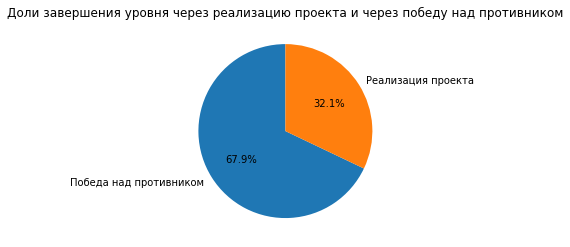

In [51]:
labels = ['Победа над противником', 'Реализация проекта']
wins = win_types['user_id']

fig1, ax1 = plt.subplots()
ax1.pie(wins, labels=labels, autopct='%1.1f%%',shadow=False,
         startangle=90)
plt.title("Доли завершения уровня через реализацию проекта и через победу над противником")

plt.show()

Посмотрим сколько и каких зданий строили игроки на первом уровне

In [52]:
buildings = actions.groupby('building_type')['event'].count().reset_index().sort_values(by = 'event', ascending = False)

In [53]:
buildings = buildings.rename(columns = {'event':'build_number'})

In [54]:
buildings

,building_type,build_number
2,spaceport,59325
0,assembly_shop,54494
1,research_center,14137


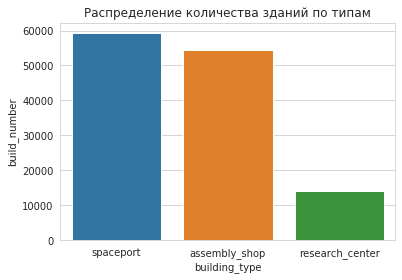

In [55]:
sns.set_style("whitegrid") 
ax = sns.barplot(data = buildings, x = 'building_type', y = 'build_number')
plt.title('Распределение количества зданий по типам')
plt.show()

Самое востребованное здание - космопорт (построено 59325 штук), немного отстает сборочный цех (54494), на последнем месте исследовательский центр (14137)

Посмотрим какое распределение построенных зданий среди игроков завершивших уровень

In [56]:
finished_user_id = finished_stage_1['user_id']

In [57]:
buildings_finished_stage = actions.query('user_id in @finished_user_id').groupby('building_type')['event'].count().reset_index().sort_values(by = 'event', ascending = False)

In [58]:
buildings_finished_stage = buildings_finished_stage.rename(columns = {'event':'build_number'})

In [59]:
buildings_finished_stage

,building_type,build_number
2,spaceport,27920
0,assembly_shop,25414
1,research_center,7452


Лидируют по прежнему космопорт и сборочный цех, и в целом пропорции распределения типов зданий те же.  
Космопорт (построено 27920 штук), немного отстает сборочный цех (25414), на последнем месте исследовательский центр (7452)

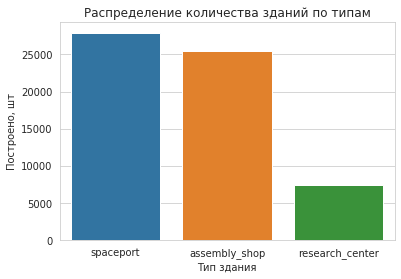

In [60]:
sns.set_style("whitegrid") 
ax = sns.barplot(data = buildings_finished_stage, x = 'building_type', y = 'build_number').set(xlabel = 'Тип здания', ylabel = 'Построено, шт')
plt.title('Распределение количества зданий по типам')
plt.show()

Посчитаем сколько зданий построил каждый игрок за время прохождения уровня

In [61]:
finished_actions = actions.query('user_id in @finished_user_id')

In [62]:
finished_actions.head()

,event_datetime,event,building_type,user_id,project_type
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
6,2020-05-04 00:00:36,building,assembly_shop,4fe0f101-694b-4e31-9740-d1d87f7208ea,NaN
8,2020-05-04 00:00:44,building,assembly_shop,65a92713-5969-48b1-8945-bfefa5063887,NaN


In [63]:
finished_buildings = finished_actions.query('event == "building"').groupby('user_id')['event'].count().reset_index()

In [64]:
finished_buildings.columns = ['user_id', 'built_cnt']

In [65]:
finished_buildings.head()

,user_id,built_cnt
0,001d39dc-366c-4021-9604-6a3b9ff01e25,8
1,003ee7e8-6356-4286-a715-62f22a18d2a1,8
2,004074f8-251a-4776-922c-8348dca1a2f6,12
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,8
4,0056c007-c082-43cc-bdef-afc49bca4cb9,3


In [66]:
finished_stage_1 = finished_stage_1.merge(finished_buildings, how = 'left', on = 'user_id')

In [67]:
finished_stage_1.head()

,event_datetime,event,building_type,user_id,project_type_x,win_type,built_cnt
0,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN,enemy_defeat,2
1,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN,enemy_defeat,2
2,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN,enemy_defeat,2
3,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN,enemy_defeat,3
4,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN,enemy_defeat,2


In [68]:
finished_stage_1['built_cnt'].min()

2

In [69]:
finished_stage_1['built_cnt'].max()

20

Игроки построили от 2 до 20 зданий

In [70]:
sns.histplot(data=finished_stage_1, x="built_cnt", bins = 19).set(title = 'Распределение количества построенных зданий', 
                                                                  xlabel='Количество зданий', ylabel='Количество игроков')
plt.show()

AttributeError: module 'seaborn' has no attribute 'histplot'

In [ ]:
buildings_finished_stage['build_number'].sum() / len(finished_user_id)

Игроки, завершившие первый уровень, построили в среднем по 10,5 зданий.  
В районе 7 построек наблюдается провал. Возможно, это влияние каких-то игровых механик, например после постройки семи зданий типа космопорт/сборочный цех открывается возможность строить иследовательский центр? В таком случае мало игроков останавливаются на семи зданиях и решают попробовать новое здание

### Выводы

Судя по первой когорте примерно в два раза больше игроков завершают уровень победой над врагом, чем реализацией проекта. 3951 игрок завершил уровень победой над врагом, 1866 - реализацией проекта.  

Самое востребованное здание у завершивших уровень - космопорт (построено 27920 штук), немного отстает сборочный цех (25414), на последнем месте исследовательский центр (7452).  
Игроки, завершившие первый уровень, построили от 2 до 20 зданий, в среднем по 10,5 зданий. 

## Проверка статистических гипотез

1я гипотеза: о различии времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком. 

Найдем id игроков завершивших уровень победой над врагом и тех кто реализовал проект

In [ ]:
defeat_user_id  = set(finished_stage_1['user_id']) - set(project_completed['user_id'])

In [ ]:
project_user_id = project_completed['user_id']

Рассчитаем время прохождения уровня.  
Найдем время первого события для завершивших первый уровень игроков

In [ ]:
first_event = finished_actions.groupby('user_id')['event_datetime'].min().reset_index()

In [ ]:
first_event.columns = ['user_id', 'first_event_time']

In [ ]:
first_event.head()

In [ ]:
finished_stage_1 = finished_stage_1.merge(first_event, on = 'user_id', how = 'left')


In [ ]:
finished_stage_1.head()

Рассчитаем время от первого события до завершения уровня

In [ ]:
finished_stage_1['time_to_finish'] = finished_stage_1['event_datetime'] - finished_stage_1['first_event_time']

In [ ]:
finished_stage_1.head()

Добавим время прохождения уровня в секундах, чтобы по этим данным можно было проводить сравнение с помощью t-теста

In [ ]:
finished_stage_1['time_to_finish_sec'] = finished_stage_1['time_to_finish'].dt.total_seconds()

Выделим две группы, по которым нужно сравнить время прохождения уровня

In [ ]:
finished_def = finished_stage_1.query('user_id in @defeat_user_id')

In [ ]:
finished_def.tail()

In [ ]:
finished_proj = finished_stage_1.query('user_id in @project_user_id')

In [ ]:
finished_proj.head()

In [ ]:
finished_def['time_to_finish'].mean()

In [ ]:
finished_proj['time_to_finish'].mean()

Судя по средним, у игроков, завершивших уровень реализацией проекта, уходит больше времени - 13,5 дней. У одолевших противника на прохождение уровня уходит в среднем 11 дней.

Проверим гипотезу о равенстве средних двух полученных совокупностей.  
H0: Среднее время прохождения уровня у группы победивших противника и группы завершивших проект не отличается.  
H1: Среднее время прохождения уровня у группы победивших противника и группы завершивших проект различаются.  

In [ ]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(finished_def['time_to_finish_sec'], finished_proj['time_to_finish_sec'], equal_var = True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Между двумя группами действительно есть статистически значимая разница во времени прохождения уровня.  


Чтобы оценить какая из двух групп потенциально приносит больше выручки, проверим **гипотезу о разнице в количестве построенных зданий за время прохождения уровня**.  

Переопределим наши группы чтобы добавить в них данные о построенных зданиях

In [ ]:
finished_def = finished_stage_1.query('user_id in @defeat_user_id')

In [ ]:
finished_proj = finished_stage_1.query('user_id in @project_user_id')

In [ ]:
finished_def['built_cnt'].mean()

In [ ]:
finished_proj['built_cnt'].mean()

Судя по средним, игроки завершившие проект, построили больше зданий.

Проверим статистическую гипотезу о равенсте средних по количеству построенных зданий между двумя группами.  
H0: Среднее количество построенных зданий прохождения уровня у группы победивших противника и группы завершивших проект не отличается.  
H1: Среднее количество построенных зданий прохождения уровня у группы победивших противника и группы завершивших проект различаются.


In [ ]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(finished_def['built_cnt'], finished_proj['built_cnt'], equal_var = True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

В количестве построенных зданий между двумя группами есть статистически значимая разница.  
Игроки, завершившие уровень реализацией проекта, строят больше зданий за время прохождения уровня.  

### Выводы

Судя по средним значениям, у игроков, завершивших уровень реализацией проекта, уходит больше времени - 13,5 дней. У одолевших противника на прохождение уровня уходит в среднем 11 дней.  
По результатам проведения t-етста между двумя группами действительно есть статистически значимая разница во времени прохождения уровня.  


Игроки реализовавшие проект, также построили больше зданий, чем те кто завершил уровень победой над противником. В среднем при прохождении с проектом 12,6 зданий, при победе над врагом - 9,4 здания. Т-тест также подтверждает, что разница в количестве построенных зданий между двумя группами статистически значима.  
При показе рекламы во время строительств зданий, игроки реализующие проект потенциально могут принести больший доход, так как строят примерно на 35% больше зданий.

## Разработка рекомендаций для модели монетизации

Рассчитаем расходы на привлечение одного игрока

In [ ]:
costs

In [ ]:
cac = costs['cost'].sum() / len(actions['user_id'].unique())

In [ ]:
cac

На привлечение одного пользователя потратили  56 центов

Проверим динамику количества событий по дням

In [ ]:
actions['event_date'] = actions['event_datetime'].dt.date

In [ ]:
actions.groupby('event_date')['event'].count()

На пике 9 мая было более 13000 событий. К 6 июня регистрировались уже только единичные события. Видимо к этому времени абсолютное большинство игроков первой когорты либо завершили уровень, либо забросили игру.  
Это означает, что нам известна окончательная модель поведения игроков (те кто еще не завершил уровень, больше не будут генерировать события). Соответственно можем рассчитывать окупаемость с учетом и тех, кто завершил уровень, и тех, кто ушел из игры. 

Посчитаем сколько зданий построили игроки

In [ ]:
buildings = actions.query('event == "building"').groupby('user_id')['event'].count().reset_index()

In [ ]:
buildings

Посчитаем среднее количество построенных зданий

In [ ]:
buildings['event'].mean()

В среднем игроки построили по 9,42 здания

Посчитаем, сколько показов рекламы нужно для покрытия стоимости привлечения одного игрока.  
Стоимость одного показа рекламы в нашей игре - 7 центов.  

In [ ]:
ad_price = 0.07

In [ ]:
cac/ad_price

Для окупаемости привлечения одного игрока нужно показать ему рекламу 8 раз

Можно попробовать показывать рекламу начиная со второй постройки.  
Либо показывать рекламу для определенной доли событий (без учета активноси конкретного игрока), например 6 раз из 7 при постройке зданий в игре показывается реклама. 

Проверим, какой доход мы получили бы от игроков на первом уровне, при модели показа рекламы начиная с 2-го здания. 

In [ ]:
buildings['income'] = ((buildings['event'] - 1).clip(0))*ad_price

In [ ]:
buildings.head()

In [ ]:
income  = buildings['income'].sum()

In [ ]:
income

Если показывать рекламу начиная со второго здания - доход составит 8006,6 долларов

Посчитаем суммарные расходы на привлечение игроков

In [ ]:
cost = costs['cost'].sum()

In [ ]:
cost

На привлечение игроков потратили 7603,6 долларов.  
Оценим прибыль при применении нашей модели

In [ ]:
(income - cost)/cost

Получилась прибыль в 5,3%

Посмотрим, что получится, если показывать рекламу 6 раз из 7 (в целом по всем игрокам)


In [ ]:
ad_display_ratio = 6/7

In [ ]:
buildings['event'].sum() * ad_display_ratio * ad_price

При такой модели маркетинговые расходы также окупились. Однако при этой модели многие игроки будут видеть рекламу начиная с первой постройки, некоторым реклама может попадать при каждой постройке здания. Первая модель выглядит предпочтительнее

### Выводы
Рекомендуемая модель монетизации: показывать игрокам рекламу при постройке зданий начиная с третьего здания.  
При такой модели расходы на привлечение игроков первой когорты окупились бы и принесли небольшую прибыль. 

## Выводы и рекомендации

Судя по первой когорте примерно в два раза больше игроков завершают уровень победой над врагом, чем реализацией проекта. 3951 игрок завершил уровень победой над врагом, 1866 - реализацией проекта.

Самое востребованное здание у завершивших уровень - космопорт (построено 27920 штук), немного отстает сборочный цех (25414), на последнем месте исследовательский центр (7452).
Игроки, завершившие первый уровень, построили от 2 до 20 зданий, в среднем по 10,5 зданий.  

Судя по средним значениям, у игроков, завершивших уровень реализацией проекта, уходит больше времени - 13,5 дней. У одолевших противника на прохождение уровня уходит в среднем 11 дней.
По результатам проведения t-етста между двумя группами действительно есть статистически значимая разница во времени прохождения уровня.

Игроки реализовавшие проект, также построили больше зданий, чем те кто завершил уровень победой над противником. В среднем при прохождении с проектом 12,6 зданий, при победе над врагом - 9,4 здания. Т-тест также подтверждает, что разница в количестве построенных зданий между двумя группами статистически значима.
При показе рекламы во время строительств зданий, игроки реализующие проект потенциально могут принести больший доход, так как строят примерно на 35% больше зданий.  

Рекомендуемая модель монетизации: показывать игрокам рекламу при постройке зданий начиная со второго здания.
При такой модели расходы на привлечение игроков первой когорты окупились бы и принесли прибыль в 5,3%.  
Однако для окупаемости рекламу нужно будет показывать практически при каждой постройке здания. Возможно, стоит рассмотреть вариант переноса части показов на другие экраны/события, например показывать рекламу при завершении уровня. 